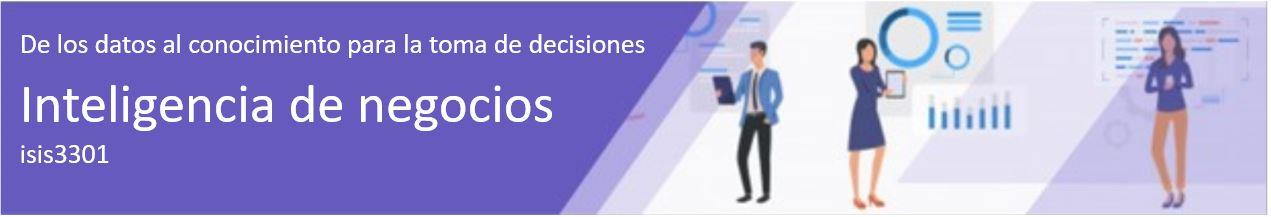

# Laboratorio 2 - Tarea de agrupación

- ### Estudiante 1: 
- ### Estudiante 2: 
- ### Estudiante 3: 


En este notebook se desarrolla un proyecto de analítica de datos para SenecaféAlpes. A partir de un conjunto de datos con atributos morfológicos de granos de café, se implementará la metodología CRISP-ML para construir y evaluar modelos de agrupación. El objetivo principal es identificar patrones naturales entre siete variedades registradas de café, aplicando algoritmos como K-Means y otras alternativas de clustering. Los resultados se validarán tanto de forma cuantitativa, como cualitativa, a través de la interpretación de los grupos encontrados en relación con los objetivos estratégicos de la organización.


Este notebook se encuentra dividido en las siguientes secciones:

ACTUALIZAR

# 1. Preparación de datos
## 1.0 Carga de librerías

In [2]:
import pandas as pd
import numpy as np
import sys
import os
import os.path as osp
import joblib

from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

## 1.2 Cargar los datos

In [5]:
# Se cargan los datos. 
df = pd.read_csv('Datos_SenecaféAlpes.csv', sep=';', encoding = "ISO-8859-1")

## 1.3 Perfilamiento de datos

In [6]:
df.shape

(14291, 19)

In [7]:
df.head()

,ï»¿ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MÃ©todoSecado
0,G006149,50836,923618.0,358.515147,181.388899,alargado,NaN,NaN,254.413847,0.804762,0.983840,0.748853,0.709632,0.007052,0.001103,0.503578,0.995321,Normal,Lavado
1,G007234,62764,1003767.0,409.207082,198.330199,Alargado,NaN,64158.0,282.689948,0.703995,0.978272,0.782807,0.690824,0.006520,0.000916,0.477237,0.984666,NaN,Natural
2,G007054,59965,994266.0,389.088529,197.967275,Alargado,0.860886,60910.0,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,Normal,Natural
3,G006619,55035,917.6,379.346822,185.390577,Alargado,0.872446,55591.0,NaN,0.799695,0.989998,0.821376,0.697811,0.006893,0.001008,0.486941,0.996380,Normal,Lavado
4,G013353,39324,737773.0,262.520242,191.176858,Alargado,0.685326,39758.0,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,Normal,Lavado


In [8]:
# Revisar las características de los datos: completitud y tipo de dato
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14291 entries, 0 to 14290
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ï»¿ID                14291 non-null  object 
 1   Area                 14291 non-null  int64  
 2   Perimetro            13054 non-null  float64
 3   LongitudEjeMayor     13890 non-null  float64
 4   LongitudEjeMenor     14291 non-null  float64
 5   RelacionAspecto      13825 non-null  object 
 6   Excentricidad        13687 non-null  float64
 7   AreaConvexa          12868 non-null  float64
 8   DiametroEquivalente  12368 non-null  float64
 9   Medida               14291 non-null  float64
 10  Solidez              11985 non-null  float64
 11  Redondez             12228 non-null  float64
 12  Compacidad           13641 non-null  float64
 13  FactorForma1         13172 non-null  float64
 14  FactorForma2         13185 non-null  float64
 15  FactorForma3         13813 non-null 

In [9]:
# Resumen de los estadisticos de las variables numéricas
df.describe()

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4
count,14291.000000,1.305400e+04,13890.000000,14291.000000,13687.000000,12868.000000,12368.000000,14291.000000,11985.000000,12228.000000,13641.000000,13172.000000,13185.000000,13813.000000,13132.000000
mean,53055.408999,7.729870e+05,319.985592,202.178613,0.749977,53575.397809,253.001741,0.749844,0.986774,0.873080,0.799242,0.006560,0.001712,0.643183,0.994292
std,29396.080372,3.266493e+05,86.378452,45.494541,0.099438,29566.387814,60.542330,0.050774,0.025947,0.063237,0.067643,0.001164,0.000601,0.100857,0.039081
min,-62716.000000,-1.012143e+06,-421.444657,-200.838672,-0.835004,-78423.000000,-448.402605,-0.798706,-0.989042,-0.896861,-0.843901,-0.007982,-0.002673,-0.683269,-0.998527
25%,36338.000000,6.768608e+05,253.319858,175.881052,0.715144,36720.000000,215.302463,0.718767,0.985597,0.832824,0.762127,0.005903,0.001151,0.581047,0.993663
50%,44660.000000,7.720345e+05,296.682345,192.437870,0.764392,45107.500000,238.579492,0.760232,0.988279,0.883353,0.800994,0.006645,0.001691,0.641648,0.996377
75%,61311.000000,9.554098e+05,376.548109,216.847844,0.810441,62109.250000,279.672481,0.786942,0.989991,0.916803,0.834405,0.007273,0.002169,0.696366,0.997889
max,254616.000000,1.921685e+06,738.860154,460.198497,0.911423,251082.000000,569.374358,0.866195,0.994378,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


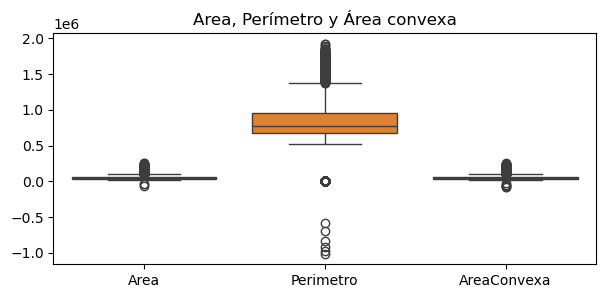

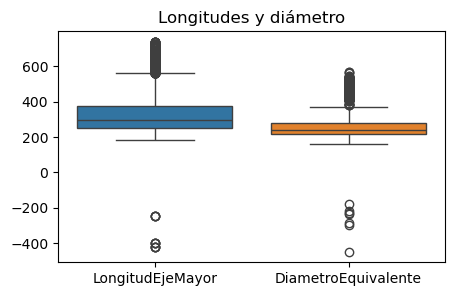

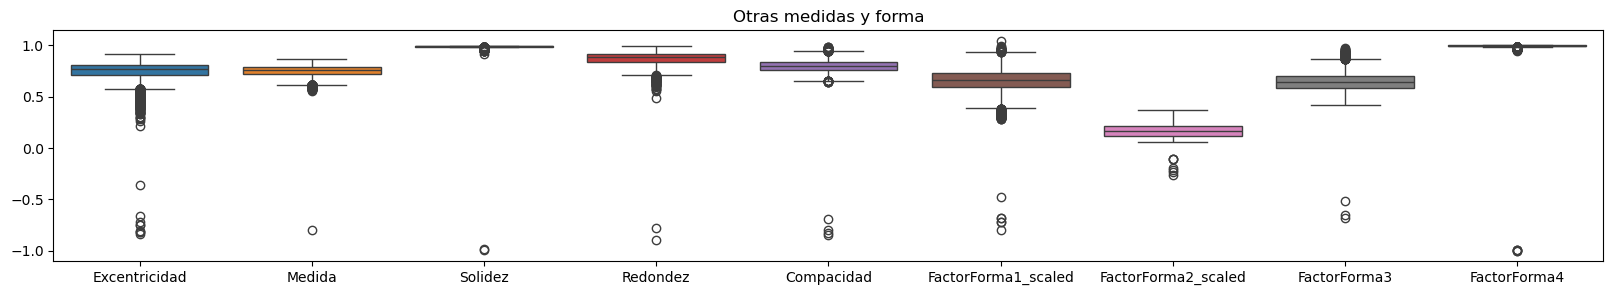

In [26]:
# Visualización de todas las variables numéricas

# graficamos por variables con dimensiones similares
# Area, Perímetro, Área convexa
fig=plt.figure(figsize=(7,3))
ax = sns.boxplot(data=df[["Area", "Perimetro", "AreaConvexa"]], orient="v")
plt.title("Area, Perímetro y Área convexa")
plt.show()

# LongitudEjes, Diámetros
fig=plt.figure(figsize=(5,3))
ax2 = sns.boxplot(data=df[["LongitudEjeMayor", "LongitudEjeMayor", "DiametroEquivalente"]], orient="v")
plt.title("Longitudes y diámetro")
plt.show()

# otras medidas y forma
df["FactorForma1_scaled"] = df["FactorForma1"]*100
df["FactorForma2_scaled"] = df["FactorForma2"]*100
fig=plt.figure(figsize=(20,3))
ax3 = sns.boxplot(data=df[["Excentricidad", "Medida", "Solidez", "Redondez", "Compacidad", "FactorForma1_scaled", "FactorForma2_scaled", "FactorForma3", "FactorForma4"]], orient="v")
plt.title("Otras medidas y forma")
plt.show()